### Initializing Python and Importing Packages

Several packages produce warnings about deprecated functions needing to be changed in the future. The initial cell changes the settings to hide these warnings to not destract from the analysis.

In [1]:
# @hidden_cell
# Get rid of annoying warnings
import warnings
warnings.filterwarnings('ignore')

All packages that are used throughout the analysis are imported in this cell

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import re
import scipy.stats as stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.metrics import roc_curve, auc, roc_auc_score

A few settings for plot visualizations are set in this cell

In [3]:
# Initialize Global Settings
plt.rc("font", size=14) # Set Font Size
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)


***
### Reading and Exploring Data

The data is read in from a formatted csv file.

In [4]:
# Read in Data and convert to pandas data frame
data_raw = pd.read_csv('hepatitis.csv',header = 0,na_values=[" "])
data = pd.DataFrame(data_raw)
#data

#### Summary Statistics of dataset:

In [5]:
# View Descriptive Statistics
data.describe()

,class,age,bilirubin,alkphosphate,sgot,albumin,protime
count,155.000000,155.000000,149.000000,126.000000,151.00000,139.000000,87.000000
mean,0.793548,41.200000,1.427517,105.325397,85.89404,3.817266,62.091954
std,0.406070,12.565878,1.212149,51.508109,89.65089,0.651523,22.896446
min,0.000000,7.000000,0.300000,26.000000,14.00000,2.100000,0.000000
25%,1.000000,32.000000,0.700000,74.250000,31.50000,3.400000,46.000000
50%,1.000000,39.000000,1.000000,85.000000,58.00000,4.000000,62.000000
75%,1.000000,50.000000,1.500000,132.250000,100.50000,4.200000,76.500000
max,1.000000,78.000000,8.000000,295.000000,648.00000,6.400000,100.000000


In [6]:
# Get count of missing values by field
data.isnull().sum()[data.isnull().sum() > 0]

bilirubin        6
alkphosphate    29
sgot             4
albumin         16
protime         68
dtype: int64

In [7]:
#Check if columns containing null values are normally distributed
column_null = data.columns[data.isnull().any()].tolist()
for c in column_null:
    print(c,':', stats.normaltest(data[c],nan_policy='omit'))

bilirubin : NormaltestResult(statistic=113.48119911198776, pvalue=2.2796633278907591e-25)
alkphosphate : NormaltestResult(statistic=35.05145105149456, pvalue=2.4472261958268189e-08)
sgot : NormaltestResult(statistic=129.32332921051136, pvalue=8.275531026340891e-29)
albumin : NormaltestResult(statistic=5.9922933698518097, pvalue=0.049979283724230918)
protime : NormaltestResult(statistic=1.4155143799474865, pvalue=0.49274809945487452)


In [8]:
# Replace missing values in protime column with random values from normal distribution
np.random.seed(31309) # Set the random seed for reproducibility
mu = data["protime"].mean()         # Calculate mean
sigma = data["protime"].std()       # Calculate standard deviation
a = data["protime"].isnull()        # Identify missing values
norm_dist = np.random.normal(mu, sigma, a.sum()) # Generate Random replacements
half = min(data["protime"]) / 2
if(np.isnan(half)):
    half = norm_dist
print("protime:", half)
data["protime"].loc[np.isnan(data["protime"])] = half # Insert the random replacements
data.isnull().sum()[data.isnull().sum() > 0]

protime: [  71.93162287   67.4715456    10.8414288    69.7531968    79.5826949
   67.81746824   57.0469538    77.6477085   105.24334199   71.44086608
   27.02594956   33.41015447   62.59388628   64.72740928   79.15838382
   74.80134606   73.40505557   70.75819194   99.5296475    56.74162847
   94.50406008   55.93824995   87.80437518   54.13171209   39.7320422
   84.93758509  108.17805478   24.01815975   50.61141422   57.53733777
   57.73668824   50.79210559   80.54368849   77.52296364   28.61731932
   38.1624156    62.55207257   73.26902173   49.71549611  108.13250514
   57.57665926   71.84902758   59.1485531    44.92131084   58.13273038
  110.47190314  111.33540781   61.6068432    67.7647404    26.95708053
   77.34376753   76.57825533   52.00437885   57.53789551   40.24986514
   96.94416295   82.07271719   57.80805521  121.91803954   55.31283263
   55.50369809   91.24069095   82.69204949   53.40435311   55.77506958
   55.54672983   51.48438716   78.34164501]


bilirubin        6
alkphosphate    29
sgot             4
albumin         16
dtype: int64

In [9]:
#Replace missing values for non normal distribution with random samples 
data = data.apply(lambda x: np.where(x.isnull(), x.dropna().sample(len(x), replace=True), x))
#data

In [10]:
# Check for missing values after replacement
data.isnull().sum()[data.isnull().sum() > 0]

Series([], dtype: int64)

In [11]:
# Means of continous variables by Class
data.groupby('class').mean()

,age,bilirubin,alkphosphate,sgot,albumin,protime
class,,,,,,
0,46.593750,2.487500,110.281250,105.875000,3.281250,50.323245
1,39.796748,1.150407,103.056911,83.398374,3.952846,67.549144


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155 entries, 0 to 154
Data columns (total 20 columns):
class             155 non-null int64
age               155 non-null int64
sex               155 non-null object
steroid           155 non-null object
antivirals        155 non-null object
fatigue           155 non-null object
malaise           155 non-null object
anorexia          155 non-null object
liverbig          155 non-null object
liverfirm         155 non-null object
spleenpalpable    155 non-null object
spiders           155 non-null object
ascites           155 non-null object
varices           155 non-null object
bilirubin         155 non-null float64
alkphosphate      155 non-null float64
sgot              155 non-null float64
albumin           155 non-null float64
protime           155 non-null float64
histology         155 non-null object
dtypes: float64(5), int64(2), object(13)
memory usage: 24.3+ KB


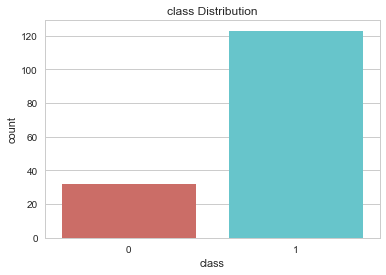

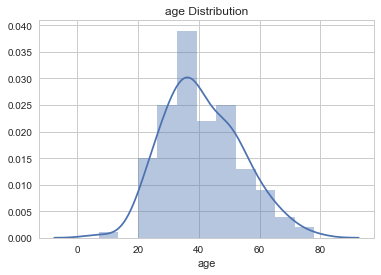

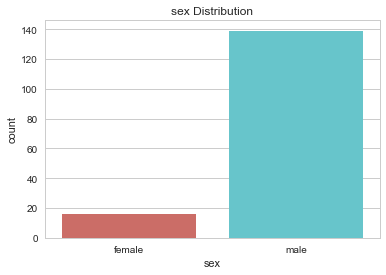

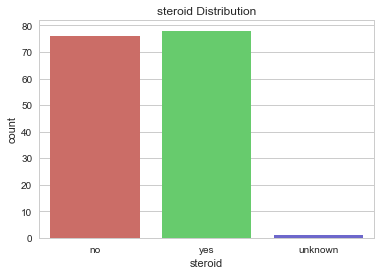

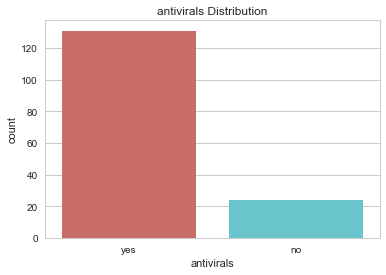

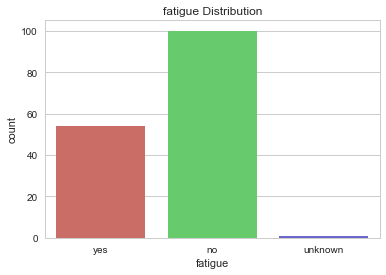

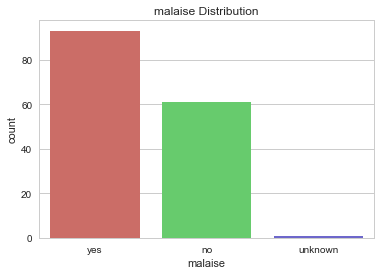

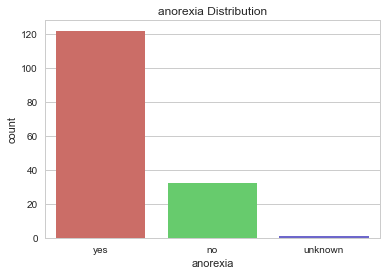

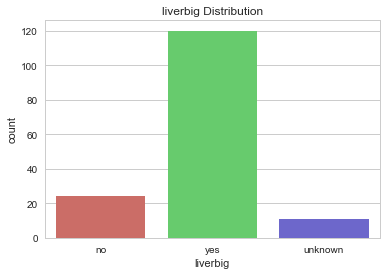

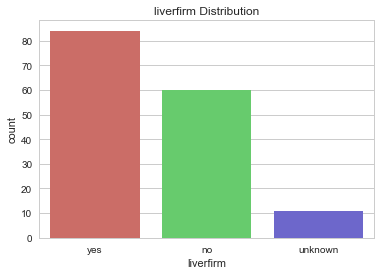

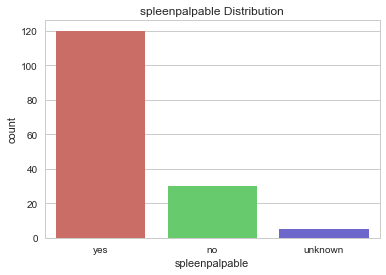

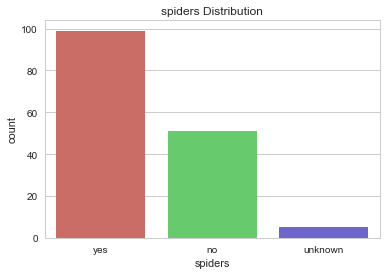

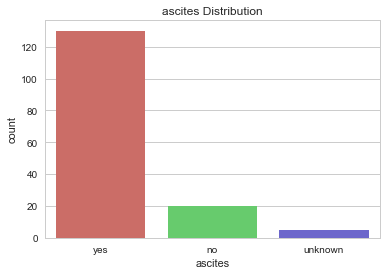

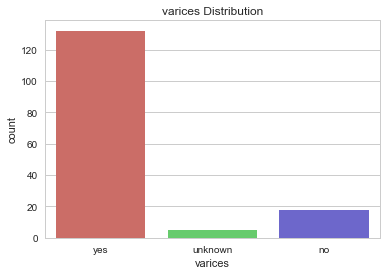

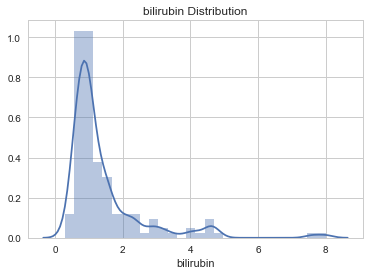

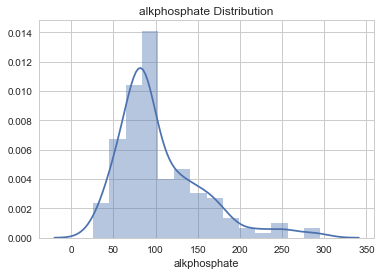

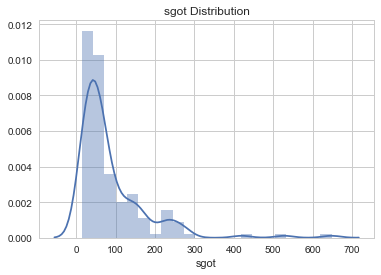

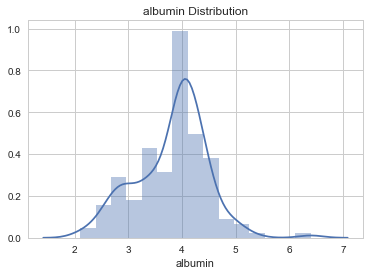

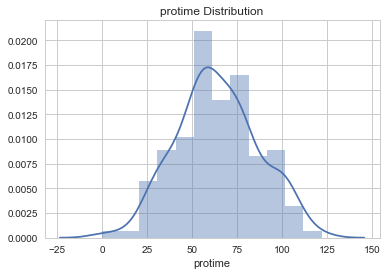

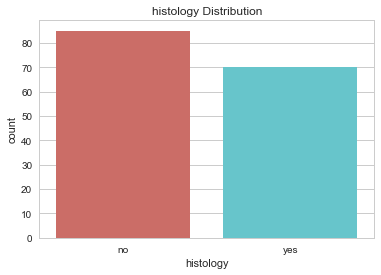

In [13]:
#Plotting
for field in data.columns.values: # Loop through fields
    if(len(data[field].unique()) <= 3): # If there are 3 or fewer unique values
        sns.countplot(x=field, data = data, palette = 'hls') # Produce a countplot
    else: 
        sns.distplot(data[field].dropna()) # Produce a distplot
    plt.title(field + " Distribution") # Add a title
    plt.show() # Show the plot
        

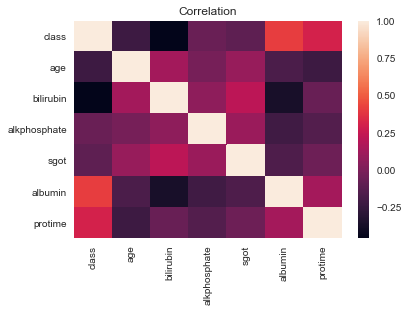

In [14]:
# Plot Correlation
x=data.corr()
sns.heatmap(x)
plt.title("Correlation")
plt.show()

In [15]:
# View correlations with class
x['class'].sort_values(ascending=False)

class           1.000000
albumin         0.409899
protime         0.306837
alkphosphate   -0.058468
sgot           -0.100510
age            -0.219647
bilirubin      -0.455198
Name: class, dtype: float64

In [16]:
#Creating Dummies
data2=pd.get_dummies(data,columns=['sex','steroid','antivirals','fatigue','malaise','anorexia','liverbig',
                                   'liverfirm','spleenpalpable','spiders','ascites','varices','histology'])
print("Data shape:", data2.shape)
for i,j in enumerate(list(data2.columns)):
    print (str(i) + ": " + j)


Data shape: (155, 43)
0: class
1: age
2: bilirubin
3: alkphosphate
4: sgot
5: albumin
6: protime
7: sex_female
8: sex_male
9: steroid_no
10: steroid_unknown
11: steroid_yes
12: antivirals_no
13: antivirals_yes
14: fatigue_no
15: fatigue_unknown
16: fatigue_yes
17: malaise_no
18: malaise_unknown
19: malaise_yes
20: anorexia_no
21: anorexia_unknown
22: anorexia_yes
23: liverbig_no
24: liverbig_unknown
25: liverbig_yes
26: liverfirm_no
27: liverfirm_unknown
28: liverfirm_yes
29: spleenpalpable_no
30: spleenpalpable_unknown
31: spleenpalpable_yes
32: spiders_no
33: spiders_unknown
34: spiders_yes
35: ascites_no
36: ascites_unknown
37: ascites_yes
38: varices_no
39: varices_unknown
40: varices_yes
41: histology_no
42: histology_yes


In [17]:
#Drop Unknown Columns
unk_idx = [i for i, col in enumerate(data2.columns) if col.endswith('unknown')] # Find columns that end with 'unknown'
data2.drop(data2.columns[[unk_idx]], axis = 1, inplace = True)




In [18]:
data2.shape

(155, 33)

In [19]:
data2.columns

Index(['class', 'age', 'bilirubin', 'alkphosphate', 'sgot', 'albumin',
       'protime', 'sex_female', 'sex_male', 'steroid_no', 'steroid_yes',
       'antivirals_no', 'antivirals_yes', 'fatigue_no', 'fatigue_yes',
       'malaise_no', 'malaise_yes', 'anorexia_no', 'anorexia_yes',
       'liverbig_no', 'liverbig_yes', 'liverfirm_no', 'liverfirm_yes',
       'spleenpalpable_no', 'spleenpalpable_yes', 'spiders_no', 'spiders_yes',
       'ascites_no', 'ascites_yes', 'varices_no', 'varices_yes',
       'histology_no', 'histology_yes'],
      dtype='object')

In [20]:
#Building Logistic Regression Model for selecting important features using Recursive Feature Elimination(RFE)
A = data2.iloc[:,1:]
b = data2.iloc[:,0]
classifier = LogisticRegression(random_state = 5)
from sklearn.feature_selection import RFE
rfe = RFE(classifier,29)
classifier = rfe.fit(A, b)
print("Num Features: %d" % (classifier.n_features_,))
print("Selected Features: %s" % (classifier.support_,))
print("Feature Ranking: %s" % (classifier.ranking_,))
data2.shape
asdf = (classifier.support_,)
q = asdf[0].tolist()
#print(q)
dip = []        
for i, j in enumerate (q) :
    if j == False:
        dip.append(i+1)
data2 = data2.drop(data2.columns[dip], axis=1)
data2.columns


Num Features: 29
Selected Features: [ True  True False False  True False  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]
Feature Ranking: [1 1 3 4 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


Index(['class', 'age', 'bilirubin', 'albumin', 'sex_female', 'sex_male',
       'steroid_no', 'steroid_yes', 'antivirals_no', 'antivirals_yes',
       'fatigue_no', 'fatigue_yes', 'malaise_no', 'malaise_yes', 'anorexia_no',
       'anorexia_yes', 'liverbig_no', 'liverbig_yes', 'liverfirm_no',
       'liverfirm_yes', 'spleenpalpable_no', 'spleenpalpable_yes',
       'spiders_no', 'spiders_yes', 'ascites_no', 'ascites_yes', 'varices_no',
       'varices_yes', 'histology_no', 'histology_yes'],
      dtype='object')

In [21]:
#Building model after feature selection
X = data2.iloc[:,1:]
y = data2.iloc[:,0]
#print(type(X))
#print(y)
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.25,random_state = 5)
#X_train.shape
#X_test.shape
#y_train.shape
#y_test.shape

In [22]:
#Building Logistic Regression Model
classifier = LogisticRegression(random_state = 5)

classifier.fit(X_train, y_train)

#Predicting and Confusion Matrix
y_pred = classifier.predict(X_test)
y_pred_prob = classifier.predict_proba(X_test)[:, 1]
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[ 4  3]
 [ 1 31]]


In [23]:
#Caluclating Accuracy
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(classifier.score(X_test, y_test)))


Accuracy of logistic regression classifier on test set: 0.90


In [24]:
#Caluclating Precision and F-score
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.80      0.57      0.67         7
          1       0.91      0.97      0.94        32

avg / total       0.89      0.90      0.89        39



In [25]:
#Weights of each feature
classifier.coef_

array([[-0.03231523, -0.38473632,  0.66840146,  1.03571073, -0.70813174,
        -0.02436312,  0.33703145,  0.03026693,  0.29731206, -0.52652755,
         0.64729834, -0.3321553 ,  0.45292608,  0.31827546, -0.19750468,
         0.57935401,  0.3719496 ,  0.69374387,  0.24736842, -0.73265052,
         0.52307134, -0.79036846,  0.58078928, -0.67468727,  0.46510809,
        -0.14819592, -0.06138326,  0.10278714,  0.22479185]])

In [26]:
#K-fold cross validation
from sklearn import model_selection
fold = model_selection.KFold(n_splits=10, random_state=7)
scores = cross_val_score(classifier, X, y, cv=fold)
print(scores)
print('average accuracy: {}'.format(scores.mean()))

[ 0.9375      0.875       0.875       0.9375      0.875       0.73333333
  0.6         0.8         0.86666667  0.8       ]
average accuracy: 0.8300000000000001


Area under ROC: 0.799107142857


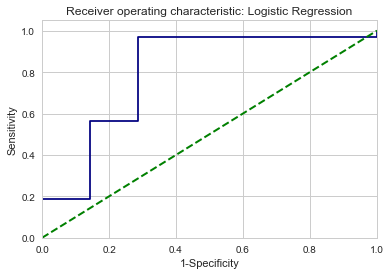

In [27]:
#Define a function to draw ROC
def drawROC(y_test, y_pred_prob, cl_name):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(2):
        fpr[i], tpr[i], th_ = roc_curve(y_test, y_pred_prob)
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    print("Area under ROC:",roc_auc_score(y_test, y_pred_prob))
    plt.figure()
    plt.plot(fpr[1], tpr[1], color = 'navy')
    plt.plot([0, 1], [0, 1], color='green', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('1-Specificity')
    plt.ylabel('Sensitivity')
    plt.title('Receiver operating characteristic: '+cl_name)
    plt.show()

#ROC of logistic Regression
drawROC(y_test, y_pred_prob, 'Logistic Regression')

In [28]:
#Support Vector Machines
from sklearn import svm

svc = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)

y_pred = svc.predict(X_test)
from sklearn.metrics import confusion_matrix
confusion_matrix1 = confusion_matrix(y_test, y_pred)
print(confusion_matrix1)

[[ 3  4]
 [ 1 31]]


In [29]:
#Caluclating Accuracy
print('Accuracy of SVM classifier on test set: {:.2f}'.format(svc.score(X_test, y_test)))

Accuracy of SVM classifier on test set: 0.87


In [30]:
#Caluclating Precision and F-score
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.75      0.43      0.55         7
          1       0.89      0.97      0.93        32

avg / total       0.86      0.87      0.86        39



In [31]:
#KNN Classifier with 3 neighbors
from sklearn.neighbors import KNeighborsClassifier
classifier_KNN = KNeighborsClassifier(n_neighbors=3)
classifier_KNN.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [32]:
#Caluclating Accuracy
print('Accuracy of KNN classifier on test set: {:.2f}'.format(classifier_KNN.score(X_test, y_test)))

Accuracy of KNN classifier on test set: 0.79


In [33]:
y_pred=classifier_KNN.predict(X_test)
#Classification Report
print(classification_report(y_test, y_pred, target_names=["0","1"]))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00         7
          1       0.82      0.97      0.89        32

avg / total       0.67      0.79      0.73        39

